## Imports

In [ ]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf
!pip install gym

!pip install free-mujoco-py
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install imageio==2.4.1
!pip install -U colabgymrender
!pip install mujoco

In [2]:
import gym
import torch.nn as nn
import torch
import numpy as np
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import optimizer
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
def make_env(env_id, seed=42, p_tremble=0.0):
    env = gym.make(env_id, render_mode='rgb_array')
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env
env = make_env('Hopper-v3') #Change to Walker-v3 for extra credit section

## Visualize Half-Cheetah Environment with Random Actions

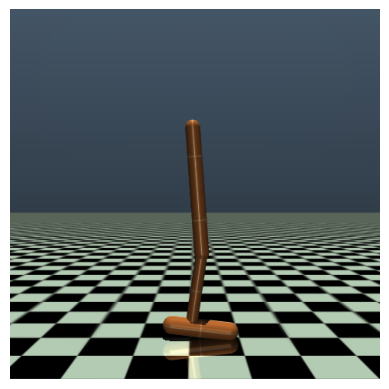

Total Reward using Random Actions =  36.19423580370582


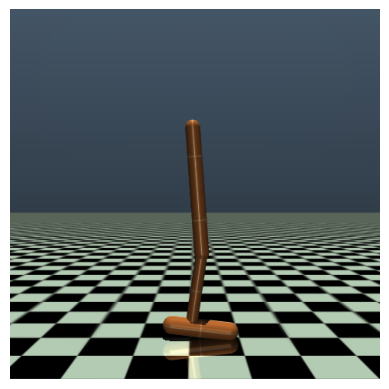

In [4]:
plt.axis('off')
done = False
obs = env.reset()
total_random_reward = 0
i = 0
while not done:
    i += 1
    if i%5==0:
        ipythondisplay.clear_output(wait=True)
        # print("At timestep = ", i)
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    total_random_reward += reward
    if done:
        break
print("Total Reward using Random Actions = ", total_random_reward)

In [ ]:
## Download hopper and walker experts
!wget https://github.com/portal-cornell/cs6756-learning-robot-decisions-fa23/raw/main/assignments/assignment2_il/experts/hopper.pt
!wget https://github.com/portal-cornell/cs6756-learning-robot-decisions-fa23/raw/main/assignments/assignment2_il/experts/walker.pt

In [6]:
LOG_STD_MAX = 2
LOG_STD_MIN = -5

class ExpertActor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale",
            torch.tensor(
                (env.action_space.high - env.action_space.low) / 2.0,
                dtype=torch.float32,
            ).reshape(1, -1),
        )
        self.register_buffer(
            "action_bias",
            torch.tensor(
                (env.action_space.high + env.action_space.low) / 2.0,
                dtype=torch.float32,
            ).reshape(1, -1),
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (
            log_std + 1
        )

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

    def get_expert_action(self, obs, random_prob=0.0):
        if np.random.random() < random_prob:
            return env.action_space.sample()
        else:
            action = self.get_action(torch.tensor([obs]).float())
            return np.array(action[0][0].detach().cpu())

ckpt_path = "hopper.pt"
expert = ExpertActor(env).to('cpu')
expert.load_state_dict(torch.load(str(ckpt_path), map_location='cpu'))

<All keys matched successfully>

### Visualize expert policy

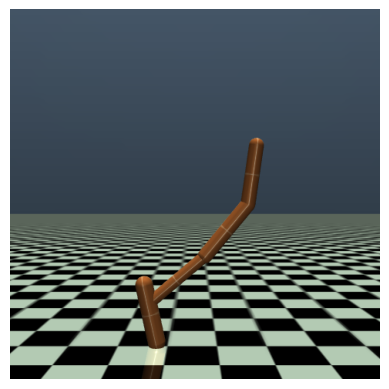

In [ ]:
plt.axis('off')
done = False
obs = env.reset()
total_expert_reward = 0
i = 0
while not done:
    i += 1
    if i%20==0:
        ipythondisplay.clear_output(wait=True)
        # print("At timestep = ", i)
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
    with torch.no_grad():
        action = expert.get_expert_action(obs)
    obs, reward, done, info = env.step(action)
    total_expert_reward += reward
    if done:
        break
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Random Actions = {total_random_reward}\n")

## Learner


In [ ]:
class Learner(nn.Module):
    def __init__(self, env, hidden_dim = 256, random_prob=0.0):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod(), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, np.prod(env.action_space.shape))

        self.env = env
        self.random_prob = random_prob

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = F.tanh(self.fc_out(x))
        return out

    def get_action(self, obs):
        if np.random.random() < self.random_prob:
            return self.env.action_space.sample()
        action = self.forward(torch.tensor([obs]).float())
        return np.array(action[0].detach().cpu())

## Behavior Cloning

### Collect and Process Offline Data

In [ ]:
NUM_TRAJS = 10
observations, actions = [], []
### Collect 10 trajectories using the expert policy

### Train BC Model


In [ ]:
## fill out the training loop
def train(learner, observations, actions, num_epochs=100):
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(learner.parameters(), lr=3e-4)
    dataset = TensorDataset(torch.tensor(observations), torch.tensor(actions)) # create your dataset
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True) # create your dataloader
    '''
    TODO: Fill out the training loop
    '''
    return learner

In [ ]:
bc_learner = Learner(env)
train(bc_learner, observations, actions, num_epochs = 100)

### Visualize learner policy and compare rewards with expert policy

Total Reward using Expert Policy = 463.6401449292952
Total Reward using Learned Policy = 114.98207344872571



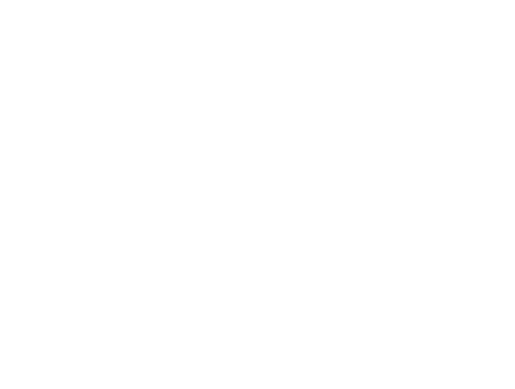

In [ ]:
done = False
obs = env.reset()
total_learner_reward = 0
i= 0
while not done:
    if i%20==0:
        ipythondisplay.clear_output(wait=True)
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
    with torch.no_grad():
        action = bc_learner.get_action(obs, random_prob = 0.01)
    obs, reward, done, info = env.step(action)
    total_learner_reward += reward
    if done:
        break
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Policy = {total_learner_reward}\n")

### Add 1% random actions to learner and check rewards


In [ ]:
bc_learner.random_prob = 0.01

## DAgger


### Initialize DAgger with BC

In [ ]:
dagger_learner = bc_learner

### Interact with environment using learner policy with random actions

In [ ]:
NUM_INTERACTIONS = 100
### Interact with the environment and aggregate your Behavior Cloning Dataset by querying the expert

## Extra Credit